In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [ ]:
train_loc = '/content/binary/output3/train'
test_loc = '/content/binary/output3/val'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 5546 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [ ]:
diagnosis_csv = '/content/binary/output3/patient_diagnosis_binary.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,Unhealthy
1,102,Healthy
2,103,Unhealthy
3,104,Unhealthy
4,105,Unhealthy


In [ ]:
categories = diagnosis['diagnosis'].unique()
categories

array(['Unhealthy', 'Healthy'], dtype=object)

In [ ]:
rn = ResNet50(weights='imagenet')
rn.summary()

x  = rn.output
prediction = Dense(2, activation='softmax', name='pred')(x)
model = Model(inputs=rn.input, outputs=prediction)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-25:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'conv5_block1_add' is trainable
Layer 'conv5_block1_out' is trainable
Layer 'conv5_block2_1_conv' is trainable
Layer 'conv5_block2_1_bn' is trainable
Layer 'conv5_block2_1_relu' is trainable
Layer 'conv5_block2_2_conv' is trainable
Layer 'conv5_block2_2_bn' is trainable
Layer 'conv5_block2_2_relu' is trainable
Layer 'conv5_block2_3_conv' is trainable
Layer 'conv5_block2_3_bn' is trainable
Layer 'conv5_block2_add' is trainable
Layer 'conv5_block2_out' is trainable
Layer 'conv5_block3_1_conv' is trainable
Layer 'conv5_block3_1_bn' is trainable
Layer 'conv5_block3_1_relu' is trainable
Layer 'conv5_block3_2_conv' is trainable
Layer 'conv5_block3_2_bn' is trainable
Layer 'conv5_block3_2_relu' is trainable
Layer 'conv5_block3_3_conv' is trainable
Layer 'conv5_block3_3_bn' is trainable
Layer 'conv5_block3_add' is trainable
Layer 'conv5_block3_out' is trainable
Layer 'avg_pool' is trainable
Layer 'predictions' is trainable
Layer 'pred' is trainable


In [ ]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
checkpoint = ModelCheckpoint("rn_base_res.h5", monitor='val_accuracy', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=2, mode='auto')

In [ ]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 20.579766536964982, 1: 1.0}

In [ ]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata,
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size,
                 epochs=50,callbacks=[checkpoint,early])

Epoch 1/50
173/173 [==============================] - ETA: 0s - loss: 1.3174 - accuracy: 0.1634 - mae: 0.5017
Epoch 1: val_accuracy improved from -inf to 0.40407, saving model to rn_base_res.h5
173/173 [==============================] - 73s 375ms/step - loss: 1.3174 - accuracy: 0.1634 - mae: 0.5017 - val_loss: 0.6957 - val_accuracy: 0.4041 - val_mae: 0.5012
Epoch 2/50
173/173 [==============================] - ETA: 0s - loss: 1.3143 - accuracy: 0.3410 - mae: 0.5019
Epoch 2: val_accuracy improved from 0.40407 to 0.48692, saving model to rn_base_res.h5
173/173 [==============================] - 61s 353ms/step - loss: 1.3143 - accuracy: 0.3410 - mae: 0.5019 - val_loss: 0.6954 - val_accuracy: 0.4869 - val_mae: 0.5011
Epoch 3/50
173/173 [==============================] - ETA: 0s - loss: 1.3049 - accuracy: 0.4784 - mae: 0.5016
Epoch 3: val_accuracy improved from 0.48692 to 0.56977, saving model to rn_base_res.h5
173/173 [==============================] - 61s 355ms/step - loss: 1.3049 - accur

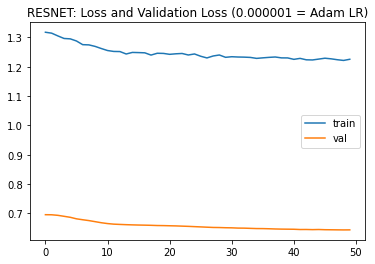

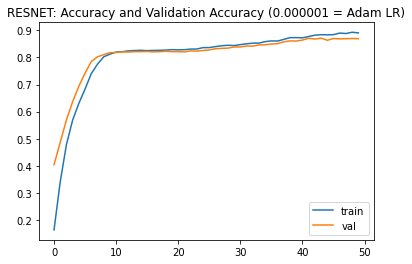

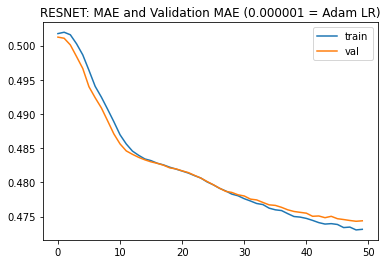

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('RESNET: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('RESNET: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('RESNET: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [ ]:
model.evaluate(testdata)

44/44 [==============================] - 19s 425ms/step - loss: 0.6439 - accuracy: 0.8691 - mae: 0.4744


[0.6439266204833984, 0.8691250681877136, 0.4743794798851013]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# predict classes of validation dataset
val_predict = model.predict(testdata)

44/44 [==============================] - 13s 264ms/step


In [ ]:
import numpy as np


In [ ]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
labels = ['Unhealthy','Healthy']
report = classification_report(testdata.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

   Unhealthy       0.04      0.15      0.07        65
     Healthy       0.95      0.84      0.89      1318

    accuracy                           0.80      1383
   macro avg       0.50      0.49      0.48      1383
weighted avg       0.91      0.80      0.85      1383



In [ ]:
cm = confusion_matrix(testdata.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['Unhealthy','Healthy'],
                     columns = ['Unhealthy','Healthy'])

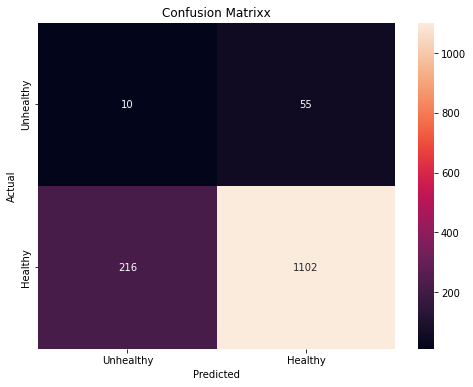

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
